# Sequence Alignement and Detecting Motifs

This work was done for the ULB course: Computational biology and bioinformatics (INFO-F-439) by Thomas Van Gysegem (all rigth reserved).

Please notice that several differences of results can occur compared to http://www.ch.embnet.org/software/LALIGN_form.html because of the algorithm they use which is a sligth modification of the one used here (citation from their software: "The lalign program implements the algorithm of Huang and Miller, published in Adv. Appl. Math. (1991) 12:337-357.")

First of all, let us introduce some utility function that will be used for this project. The first one is a function that will be used to display our Dynamic Programing matrice:

In [6]:
%%html
<style>
.outter td, .outter, .outter tr, .outter th {padding: 1px;}
.inner td, .inner, .inner tr, .inner th {border:none!important;}
.inner td, .inner tr, .inner th {width: 20px; height: 20px}
.optimal td, .optimal, .optimal tr, .optimal th {border:2px!important; color: red;}
</style>

In [7]:
from IPython.display import HTML, display

def display_dp_matrix(dp_matrix, x, y, backtrack_matrix, optimal_path):
    """ Simple display function that shows all informations about the DP matrice, sequences, ... """
    
    html_str = '<table class="outter">'
    
    # First row (header)
    html_str += '<tr><td></td><td></td><td>{}</td></tr>'.format('</td><td>'.join(_ for _ in y))
    
    for i in range(len(dp_matrix)):
        row = dp_matrix[i]
        
        c = '' if i <= 0 else x[i - 1]
        
        html_str += '<tr><td>{}</td>'.format(c)
        
        for j in range(len(row)):
            value = row[j]
            
            upleft = '<img src="upleft.png" height="42" width="9" />' if backtrack_matrix[i][j][0] else ''
            up = '<img src="up.png" height="9" width="9" />' if backtrack_matrix[i][j][1] else ''
            left = '<img src="left.png" height="9" width="9" />' if backtrack_matrix[i][j][2] else ''
            
            upleft = '<img src="upleftred.png" height="42" width="9" />' if optimal_path_direction[i][j][0] else upleft
            up = '<img src="upred.png" height="9" width="9" />' if optimal_path_direction[i][j][1] else up
            left = '<img src="leftred.png" height="9" width="9" />' if optimal_path_direction[i][j][2] else left
            
            optimal = ' optimal' if optimal_path[i][j] else ''
            
            sub_table = '<table class="inner{}"><tr><td>{}</td><td>{}</td></tr>'.format(optimal, upleft, up)
            sub_table += '<tr><td>{}</td><td>{}</td></tr></table>'.format(left, int(value))
            
            html_str += '<td>{}</td>'.format(sub_table)
        
        html_str += '</tr>'
    
    html_str += '</table>'
    
    display(HTML(html_str))

The second one will be used to parse BLOSUM and PAM matrices used. For simplicity sake we will use a 2D Python dictionnary:

In [8]:
def parse_ranking_matrix(filename):
    """ Parse a ranking matrix file with comment line beginning with # """
    ranking_matrix = {}
    
    header = []
    metadata_parsed = False
    
    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()
            
            # Ignore empty or comment line
            if line == "" or line.startswith('#'):
                continue
            
            # First line of data: Header
            elif not metadata_parsed:
                header = [_ for _ in line if _ != ' ']
                metadata_parsed = True
            
            # Other lines
            else:
                data = line.split(' ')
                
                key1 = data[0]
                data = [_ for _ in data[1:] if _ != '']
                
                ranking_matrix[key1] = {}
                for i in range(len(data)):
                    key2 = header[i]
                    value = int(data[i])
                    
                    ranking_matrix[key1][key2] = value
        
        return ranking_matrix

This function is used to display solutions with human readable formatting (showing gap, matches and so on)

In [9]:
def display_solution(solution, x, y):
    lines = ['', '', '']
    
    solution = solution[::-1]
    
    # Append the begginning
    i, j = solution[0]
    
    if i == 0:
        for _j in range(j-1):
            lines[0] += '<td>-</td>'
            lines[1] += '<td></td>'
            lines[2] += '<td>{}</td>'.format(y[_j])
    elif j == 0:
        for _i in range(i-1):
            lines[0] += '<td>{}</td>'.format(x[_i])
            lines[1] += '<td></td>'
            lines[2] += '<td>-</td>'
    
    # Take the most upper-left point from the first cell of the solution as the previous one
    # This will force a match for the first cell solution if the solution begin in the middle of the matrix
    # And a gap if it begin on the up or left border
    pi, pj = max(solution[0][0] - 1, 0), max(solution[0][1] - 1, 0)
    
    for i, j in solution:
        # Matched
        if (i - pi) + (j - pj) == 2:
            lines[0] += '<td bgcolor="#00FF11"><b>{}</b></td>'.format(x[i-1])
            lines[1] += '<td>|</td>'
            lines[2] += '<td bgcolor="#00FF11"><b>{}</b></td>'.format(y[j-1])
        elif (i - pi) == 1:
            lines[0] += '<td>{}</td>'.format(x[i-1])
            lines[1] += '<td></td>'
            lines[2] += '<td>-</td>'
        elif (j - pj) == 1:
            lines[0] += '<td>-</td>'
            lines[1] += '<td></td>'
            lines[2] += '<td>{}</td>'.format(y[j-1])
        
        pi, pj = i, j
    
    # Append the end
    if pi == M - 1:
        for j in range(pj+1, N):
            lines[0] += '<td>-</td>'
            lines[1] += '<td></td>'
            lines[2] += '<td>{}</td>'.format(y[j-1])
    elif pj == N - 1:
        for i in range(pi+1, M):
            lines[0] += '<td>{}</td>'.format(x[i-1])
            lines[1] += '<td></td>'
            lines[2] += '<td>-</td>'
    
    lines[0] = '<table class="inner"><tr>{}</tr>'.format(lines[0])
    lines[1] = '<tr>{}</tr>'.format(lines[1])
    lines[2] = '<tr>{}</tr></table>'.format(lines[2])
    
    display(HTML(''.join(lines)))

The variables used are as follows:
* `dp_matrix` is the main matrix computed with a recursive definition of the value of each cells like seen in the course.
* W and V matrices are the same as the ones from the course
* `q` is the ranking matrix (BLOSOM, PAM, ... depending which one you choosed to parse
* gap_penalty is, of course, the penalty for introducing a gap
* i_gap_penalty is the penalty for introducing a gap
* e_gap_penalty is the penalty for extending a gap
* bactrack_matrix is a somewhat hacky matrix that stores which way we come from for a given cell of the dp_matrix. Each cell is a list of 3 boolean, the first one is True if we come from the upper left cell (so a match occured), the second one is True if we introduced a gap in Y and the last one is True if we introduced a gap in X.
* optimal_path is a list of boolean, True if one optimal solution goes through it, False otherwise. It is used purely for display
* optimal_path_direction is like backtrack_matrix but for showing red arrows instead of black ones.
* l_solutions is a list of list of ordered positions in dp_matrix, each list in l_solutions is an optimal solution (up to k solutions)

## Part 1: Sequence Alignement Algorithms

This is the first part of the assignement.

First, please input your sequences here and how many optimal solutions you want (k):

In [10]:
x = 'WYFGKLGRKDAERQLLSFGNPRGTFLIRESQTTKGAYSLSIRDWDDMKGDHVKHYKIRKLDNGGYYITTRAQFETLQQLVQHYSERAAGLCCRLVVPC'
y = 'WYYGKVTRHQAEMALNERGHEGDFLIRDSESSPNDFSVSLKAQGKNKHFKVQLKETVYCIGQRKFSTMEELVEHYKKAPIFTSEQGEKLYLVKHL'
k = 3

# True to disable rendering of table (can solve lag issues)
large_matrice = True

Then, we need to load a ranking matrix and sepcify a gap penalty value

In [11]:
filename = 'BLOSUM62'
q = parse_ranking_matrix(filename)

# Use same values for both of those variables to have a linear gap penalty
i_gap_penalty = -10
e_gap_penalty = -1

In [12]:
M, N, dp_matrix, W, V = None, None, None, None, None
backtrack_matrix, optimal_path, optimal_path_direction, to_zero = None, None, None, None

### Needleman-Wunsch (global)

In [13]:
import numpy as np

def reset_optimal():
    global M, N, optimal_path, optimal_path_direction
    
    optimal_path = np.zeros((M, N), dtype=bool)

    optimal_path_direction = []
    for i in range(M):
        optimal_path_direction.append([])

        for j in range(N):
            optimal_path_direction[i].append([False, False, False])

def init_data_structures():
    """ Initialisation of data structures """
    global M, N, dp_matrix, W, V, backtrack_matrix, optimal_path, optimal_path_direction, to_zero
    
    M = len(x) + 1
    N = len(y) + 1
    
    dp_matrix = np.zeros((M, N))
    W = np.zeros((M, N))
    V = np.zeros((M, N))
    
    to_zero = np.zeros((M, N), dtype=bool)

    backtrack_matrix = []
    for i in range(M):
        backtrack_matrix.append([])

        for j in range(N):
            backtrack_matrix[i].append([False, False, False])
    
    reset_optimal()

init_data_structures()

In [14]:
"""
# Initialise non-zero gap penalty
for i in range(M):
    dp_matrix[i][0] = gap_penalty * i
    backtrack_matrix[i][0] = [False, True, False]
    
for j in range(N):
    dp_matrix[0][j] = gap_penalty * j
    backtrack_matrix[0][j] = [False, False, True]
    
backtrack_matrix[0][0] = [False, False, False]
"""
pass

In [15]:
def compute_dp_matrix(local_alignement=False):
    """ Nested loop to process all the DP matrix """
    global x, y, M, N, dp_matrix, W, V, backtrack_matrix, i_gap_penalty, e_gap_penalty, to_zero
    
    for i in range(1, M):
        for j in range(1, N):
            # This cell is forced to be zero
            if to_zero[i][j]:
                dp_matrix[i][j] = 0
                V[i][j] = 0
                W[i][j] = 0
                
                backtrack_matrix[i][j] = [False, False, False]
                continue
            
            key1 = x[i - 1]
            key2 = y[j - 1]

            V[i][j] = max(
                dp_matrix[i - 1][j] + i_gap_penalty,
                V[i - 1][j] + e_gap_penalty
            )

            W[i][j] = max(
                dp_matrix[i][j - 1] + i_gap_penalty,
                W[i][j - 1] + e_gap_penalty
            )

            no_gap = dp_matrix[i - 1][j - 1] + q[key1][key2]

            value = max(no_gap, W[i][j], V[i][j])

            if local_alignement:
                value = max(0, value)

            dp_matrix[i][j] = value

            backtrack_matrix[i][j] = [
                no_gap == value,
                V[i][j] == value,
                W[i][j] == value
            ]

compute_dp_matrix()

In [16]:
# A bit of backtracking now
def backtrack(solution, i, j, ignore):
    global optimal_path, backtrack_matrix
    
    solution.append((i, j))
    
    optimal_path[i][j] = True
    
    if True not in backtrack_matrix[i][j]:
        return True
    
    if backtrack_matrix[i][j][0]: 
        if ignore == 0:
            optimal_path_direction[i][j][0] = True
            return backtrack(solution, i-1, j-1, ignore)
        else:
            ignore -=1
    if backtrack_matrix[i][j][1]: 
        if ignore == 0:
            optimal_path_direction[i][j][1] = True
            return backtrack(solution, i-1, j, ignore)
        else:
            ignore -=1
    if backtrack_matrix[i][j][2]: 
        if ignore == 0:
            optimal_path_direction[i][j][2] = True
            return backtrack(solution, i, j-1, ignore)
        else:
            ignore -=1
    
    return False

def find_k_solutions(k, local_alignement=False):
    """ Find at most k solutions """
    l_solution = []
    for ignore in range(k):
        solution = []

        # Find better score in last row
        max_score = None
        max_position = None
        for i in range(M):
            for j in range(N):
                if not local_alignement and i != M-1 and j != N-1:
                    continue
                    
                if max_score == None or dp_matrix[i][j] > max_score:
                    max_score = dp_matrix[i][j]
                    max_position = (i, j)

        backtrack(solution, max_position[0], max_position[1], ignore)

        i, j = solution[-1]
        if True not in backtrack_matrix[i][j]:
            l_solution.append(solution)

    if not large_matrice:
        display_dp_matrix(dp_matrix, x, y, backtrack_matrix, optimal_path)

    for i in range(len(l_solution)):
        print("Solution #{}:".format(i+1))
        display_solution(l_solution[i], x, y)
    
    return l_solution

_ = find_k_solutions(k)

Solution #1:


W,Y,F,G,K,L,G,R,K,D,A,E,R,Q,L,L,S,F,G,N,P,R,G,T,F,L,I,R,E,S,Q,T,T,K,G,A,Y,S,L,S,I,R,D,W,D,D,M,K,G,D,H,V,K,H,Y,K,I,R,K,L,D,N,G,G,Y,Y,I,T,T,R,A,Q,F,E,T,L,Q,Q,L,V,Q,H,Y,S,E,R,A,A,G,L,C,C,R,L,V,V,P,C,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,,,,,|,|,|,|,|,,|,|,|,|,|,,|,|,|,|,|,,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,,,|,,,,,,,|,,,|,|,|,,,,,,,,,,,,,,,
W,Y,Y,G,K,V,T,R,H,Q,A,E,M,A,L,N,E,R,G,H,-,E,G,D,F,L,I,R,D,S,E,S,S,P,N,D,F,S,V,S,L,K,-,-,-,-,A,Q,G,K,N,-,K,H,F,K,V,-,Q,L,K,E,T,-,V,Y,C,I,G,Q,R,K,F,S,T,M,E,E,L,V,E,H,Y,-,-,K,-,-,-,-,-,-,K,-,-,A,P,I,F,T,S,E,Q,G,E,K,L,Y,L,V,K,H,L


### Smith-Waterman(local)

In [17]:
x = 'THISLINE'
y = 'ISALIGNED'
k = 3
local_count = 2 # How many local solution we want

# True to disable rendering of table (can solve lag issues)
large_matrice = False

filename = 'BLOSUM62'
q = parse_ranking_matrix(filename)

# Use same values for both of those variables to have a linear gap penalty
i_gap_penalty = -4
e_gap_penalty = -4

init_data_structures()

for _ in range(local_count):
    reset_optimal()
    compute_dp_matrix(local_alignement=True)
    
    l_solutions = find_k_solutions(k, local_alignement=True)
    
    solution = l_solutions[0]
    
    for i, j in solution:
        to_zero[i][j] = True

Solution #1:


T,H,I,S,-,L,I,-,N,E,-
,,|,|,,|,|,,|,|,
-,-,I,S,A,L,I,G,N,E,D


Solution #1:


T,H,I,S,L,I,N
,,,,,|,|
-,-,-,-,-,I,S


## Results

In [18]:
large_matrice = True # !!! Do not set to False !!! (or be patient)
l_sequences = [
    'VPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRK',
    'SPLPPGWEERQDILGRTYYVNHESRRTQWKRPTP',
    'GPLPPGWEERTHTDGRIFYINHNIKRTQWEDPRL',
    'EKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSG',
    'SGAKSMWTEHKSPDGRTYYYNTETKQSTWEKPDD',
    'LLSKCPWKEYKSDSGKPYYYNSQTKESRWAKPKE',
]

k = 3

# True to disable rendering of table (can solve lag issues)
large_matrice = True

filename = 'BLOSUM62'
q = parse_ranking_matrix(filename)

# Use same values for both of those variables to have a linear gap penalty
i_gap_penalty = -8
e_gap_penalty = -8

count = 0
for i in range(len(l_sequences[:-1])):
    x = l_sequences[i]
    
    for y in l_sequences[i+1:]:
        count += 1
        print("Test #{}: x: {}, y: {}".format(count, x, y))
        
        init_data_structures()
        compute_dp_matrix(local_alignement=False)
        
        find_k_solutions(k)
        

Test #1: x: VPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRK, y: SPLPPGWEERQDILGRTYYVNHESRRTQWKRPTP
Solution #1:


V,P,L,P,A,G,W,E,M,A,K,T,S,S,G,Q,R,Y,F,L,N,H,I,D,Q,T,T,T,W,Q,D,P,R,K
|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|
S,P,L,P,P,G,W,E,E,R,Q,D,I,L,G,R,T,Y,Y,V,N,H,E,S,R,R,T,Q,W,K,R,P,T,P


Test #2: x: VPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRK, y: GPLPPGWEERTHTDGRIFYINHNIKRTQWEDPRL
Solution #1:


V,P,L,P,A,G,W,E,M,A,K,T,S,S,G,Q,R,Y,F,L,N,H,I,D,Q,T,T,T,W,Q,D,P,R,K
|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|
G,P,L,P,P,G,W,E,E,R,T,H,T,D,G,R,I,F,Y,I,N,H,N,I,K,R,T,Q,W,E,D,P,R,L


Test #3: x: VPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRK, y: EKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSG
Solution #1:


V,P,L,P,A,G,W,E,M,A,K,T,-,S,S,G,Q,R,Y,F,L,N,H,I,D,Q,T,T,T,W,Q,D,P,R,K
|,|,|,|,|,|,|,|,|,|,|,|,,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|
E,K,L,P,P,G,W,E,K,R,M,S,R,S,S,G,R,V,Y,Y,F,N,H,I,T,N,A,S,Q,W,E,R,P,S,G


Test #4: x: VPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRK, y: SGAKSMWTEHKSPDGRTYYYNTETKQSTWEKPDD
Solution #1:


V,P,L,P,A,G,W,E,M,A,K,T,S,S,G,Q,R,Y,F,L,N,H,I,D,Q,T,T,T,W,Q,D,P,R,K
|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|
S,G,A,K,S,M,W,T,E,H,K,S,P,D,G,R,T,Y,Y,Y,N,T,E,T,K,Q,S,T,W,E,K,P,D,D


Test #5: x: VPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRK, y: LLSKCPWKEYKSDSGKPYYYNSQTKESRWAKPKE
Solution #1:


V,P,L,P,A,G,W,E,M,A,K,T,S,S,G,Q,R,Y,F,L,N,H,I,D,Q,T,T,T,W,Q,D,P,R,K
|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|
L,L,S,K,C,P,W,K,E,Y,K,S,D,S,G,K,P,Y,Y,Y,N,S,Q,T,K,E,S,R,W,A,K,P,K,E


Test #6: x: SPLPPGWEERQDILGRTYYVNHESRRTQWKRPTP, y: GPLPPGWEERTHTDGRIFYINHNIKRTQWEDPRL
Solution #1:


S,P,L,P,P,G,W,E,E,R,Q,D,I,L,G,R,T,Y,Y,V,N,H,E,S,R,R,T,Q,W,K,R,P,T,P
|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|
G,P,L,P,P,G,W,E,E,R,T,H,T,D,G,R,I,F,Y,I,N,H,N,I,K,R,T,Q,W,E,D,P,R,L


Test #7: x: SPLPPGWEERQDILGRTYYVNHESRRTQWKRPTP, y: EKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSG
Solution #1:


S,P,L,P,P,G,W,E,E,R,Q,D,-,I,L,G,R,T,Y,Y,V,N,H,E,S,R,R,T,Q,W,K,R,P,T,P
|,|,|,|,|,|,|,|,|,|,|,|,,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|
E,K,L,P,P,G,W,E,K,R,M,S,R,S,S,G,R,V,Y,Y,F,N,H,I,T,N,A,S,Q,W,E,R,P,S,G


Test #8: x: SPLPPGWEERQDILGRTYYVNHESRRTQWKRPTP, y: SGAKSMWTEHKSPDGRTYYYNTETKQSTWEKPDD
Solution #1:


S,P,L,P,P,G,W,E,E,R,Q,D,I,L,G,R,T,Y,Y,V,N,H,E,S,R,R,T,Q,W,K,R,P,T,P
|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|
S,G,A,K,S,M,W,T,E,H,K,S,P,D,G,R,T,Y,Y,Y,N,T,E,T,K,Q,S,T,W,E,K,P,D,D


Test #9: x: SPLPPGWEERQDILGRTYYVNHESRRTQWKRPTP, y: LLSKCPWKEYKSDSGKPYYYNSQTKESRWAKPKE
Solution #1:


-,-,S,P,L,P,P,G,W,E,E,R,Q,D,I,L,G,R,T,Y,Y,V,N,H,E,S,R,R,T,Q,W,K,R,P,T,P
,,|,|,|,,|,,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|
L,L,S,K,C,-,P,-,W,K,E,Y,K,S,D,S,G,K,P,Y,Y,Y,N,S,Q,T,K,E,S,R,W,A,K,P,K,E


Test #10: x: GPLPPGWEERTHTDGRIFYINHNIKRTQWEDPRL, y: EKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSG
Solution #1:


G,P,L,P,P,G,W,E,E,R,-,T,H,T,D,G,R,I,F,Y,I,N,H,N,I,K,R,T,Q,W,E,D,P,R,L
|,|,|,|,|,|,|,|,|,|,,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|
E,K,L,P,P,G,W,E,K,R,M,S,R,S,S,G,R,V,Y,Y,F,N,H,I,T,N,A,S,Q,W,E,R,P,S,G


Test #11: x: GPLPPGWEERTHTDGRIFYINHNIKRTQWEDPRL, y: SGAKSMWTEHKSPDGRTYYYNTETKQSTWEKPDD
Solution #1:


G,P,L,P,P,G,W,E,E,R,T,H,T,D,G,R,I,F,Y,I,N,H,N,I,K,R,T,Q,W,E,D,P,R,L
|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|
S,G,A,K,S,M,W,T,E,H,K,S,P,D,G,R,T,Y,Y,Y,N,T,E,T,K,Q,S,T,W,E,K,P,D,D


Test #12: x: GPLPPGWEERTHTDGRIFYINHNIKRTQWEDPRL, y: LLSKCPWKEYKSDSGKPYYYNSQTKESRWAKPKE
Solution #1:


G,P,L,P,P,-,G,W,E,E,R,T,H,T,D,G,R,I,F,Y,I,N,H,N,I,K,R,T,Q,W,E,D,P,R,L
,|,|,|,|,,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|
-,L,L,S,K,C,P,W,K,E,Y,K,S,D,S,G,K,P,Y,Y,Y,N,S,Q,T,K,E,S,R,W,A,K,P,K,E


Test #13: x: EKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSG, y: SGAKSMWTEHKSPDGRTYYYNTETKQSTWEKPDD
Solution #1:


E,K,L,P,P,G,W,E,K,R,M,S,R,S,S,G,R,V,Y,Y,F,N,H,I,T,N,A,S,Q,W,E,R,P,S,G
|,|,|,|,|,|,|,|,|,|,|,|,,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|
S,G,A,K,S,M,W,T,E,H,K,S,-,P,D,G,R,T,Y,Y,Y,N,T,E,T,K,Q,S,T,W,E,K,P,D,D


Test #14: x: EKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSG, y: LLSKCPWKEYKSDSGKPYYYNSQTKESRWAKPKE
Solution #1:


-,-,E,K,L,P,P,G,W,E,K,R,M,S,R,S,S,G,R,V,Y,Y,F,N,H,I,T,N,A,S,Q,W,E,R,P,S,G
,,|,|,|,,|,,|,,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|
L,L,S,K,C,-,P,-,W,-,K,E,Y,K,S,D,S,G,K,P,Y,Y,Y,N,S,Q,T,K,E,S,R,W,A,K,P,K,E


Test #15: x: SGAKSMWTEHKSPDGRTYYYNTETKQSTWEKPDD, y: LLSKCPWKEYKSDSGKPYYYNSQTKESRWAKPKE
Solution #1:


S,G,A,K,S,M,W,T,E,H,K,S,P,D,G,R,T,Y,Y,Y,N,T,E,T,K,Q,S,T,W,E,K,P,D,D
|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|,|
L,L,S,K,C,P,W,K,E,Y,K,S,D,S,G,K,P,Y,Y,Y,N,S,Q,T,K,E,S,R,W,A,K,P,K,E


For the checked value (using http://www.ch.embnet.org/software/LALIGN_form.html), this notebook show similar results. Unfortunately, I was not able to find how to check the sequence ancestor to find if they have some relatives in common.

## Part 2: Detecting motifs by aligning sequences to PSSMs

Using the CLUSTAL Omega tool, I created the MSA file "msaresults-CLUSTAL.fasta" using the file "to-be-aligned.fasta" as an input file.

First, lets define a function to display our profile:

In [69]:
def display_profile(seq_size, l_amino_acid, n, f):
    header = ""
    rows = ""
    
    for i in range(seq_size):
        header += "<th>{}</th>".format(i)
        
    for b in l_amino_acid:
        row = ""
        for value in f[b]:
            if value == 0:
                row += "<td></td>"
            elif value < 0:
                row += "<td style='color: red'>{:.2f}</td>".format(round(value, 2))
            else:
                row += "<td>{:.2f}</td>".format(round(value, 2))
            
        rows += "<tr><th>{}</th>{}</tr>".format(b, row)
    
    display(HTML("""
        <table>
            <tr><td></td>{}</tr>{}
        </table>
    """.format(header, rows)))

P is obtained using: http://web.expasy.org/docs/relnotes/relstat.html (accessed: 19/03/2017)
* 6 AMINO ACID COMPOSITION
* 6.1 Composition in percent for the complete database

For pseudocounts, I used Alpha as Nseq - 1 and Beta as square root of Nseq

In [77]:
import math

l_sequence = []
l_amino_acid = 'ARNDCQEGHILKMFPSTWYV'

with open("msaresults-CLUSTAL.fasta", 'r') as file:
    for line in file:
        # Ignore meta data
        if line.startswith('>'):
            continue
        
        l_sequence.append(line.strip('\n'))

n = {}

seq_size = len(l_sequence[0])

# Compute matrice n, occurences of amino acid b in position u of any sequence
# For each amino acid
for b in l_amino_acid:
    n[b] = []
    # For each position in any sequence
    for u in range(seq_size):
        n[b].append(0)
        
        # For each sequence
        for seq in l_sequence:
            if seq[u] == b:
                n[b][u] += 1

Nseq = float(len(l_sequence))

# Compute f frequency for each amino acid to be in a given position
f = {}
for b in l_amino_acid:
    f[b] = []
    # For each position in any sequence
    for u in range(seq_size):
        f[b].append(n[b][u] / Nseq)
        
alpha = Nseq - 1
beta = math.sqrt(Nseq)

p = {'A': 8.26, 
     'R': 5.53,
     'N': 4.06,
     'D': 5.46,
     'C': 1.37,
     'Q': 3.93,
     'E': 6.74,
     'G': 7.08,
     'H': 2.27,
     'I': 5.93,
     'L': 9.65,
     'K': 5.82,
     'M': 2.41,
     'F': 3.86,
     'P': 4.72,
     'S': 6.60,
     'T': 5.35,
     'W': 1.09,
     'Y': 2.92,
     'V': 6.86,
}

# Compute q (optimized frequency)
q = {}
for a in l_amino_acid:
    q[a] = []
    # For each position in any sequence
    for u in range(seq_size):
        q[a].append(((alpha * f[a][u]) + (beta * p[a])) / (alpha + beta))
        #q[a].append((n[a][u] + (beta * p[a])) / (Nseq + beta))

m = {}
for a in l_amino_acid:
    m[a] = []
    # For each position in any sequence
    for u in range(seq_size):
        m[a].append(math.log(q[a][u] / p[a], 10))

print("Amino acids:", l_amino_acid)
print("Nseq:", Nseq)
print("Alpha:", alpha)
print("Beta:", beta)
print("p:", p)

print("f:")
display_profile(seq_size, l_amino_acid, n, f)

print("q:")
display_profile(seq_size, l_amino_acid, n, q)

print("m:")
display_profile(seq_size, l_amino_acid, n, m)


Amino acids: ARNDCQEGHILKMFPSTWYV
Nseq: 247.0
Alpha: 246.0
Beta: 15.716233645501712
p: {'N': 4.06, 'R': 5.53, 'I': 5.93, 'C': 1.37, 'Y': 2.92, 'A': 8.26, 'D': 5.46, 'L': 9.65, 'G': 7.08, 'Q': 3.93, 'E': 6.74, 'T': 5.35, 'S': 6.6, 'W': 1.09, 'P': 4.72, 'K': 5.82, 'H': 2.27, 'M': 2.41, 'F': 3.86, 'V': 6.86}
f:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
A,0.02,0.03,0.01,0.08,0.00,,,0.02,0.14,,0.04,0.09,0.03,,,0.04,0.00,,,0.03,,0.06,0.02,0.03,,0.00,,0.01,,,,,,,,,,,,,,,,,,,,,,,0.03,0.00,0.03,,0.02,,,0.03,0.02
R,,0.01,0.02,0.06,0.01,,0.02,0.09,0.28,0.02,,0.07,0.02,0.03,0.04,0.45,0.09,,,,,0.03,0.04,0.01,0.03,,,,,,,,,0.02,,,,,,,,,,,,,,,,0.29,0.11,0.02,0.05,,0.01,0.21,,0.33,0.03
N,0.01,0.00,0.04,0.01,0.05,,,,0.01,0.01,,0.04,0.04,0.11,0.01,,,,,,0.54,0.02,0.32,0.13,,,,,,,0.02,,,,,,,,,,,,,,,0.00,,,0.06,0.04,,,,,0.00,0.04,,,0.01
D,0.12,,0.01,0.04,0.02,,,,0.00,0.01,0.47,0.06,0.09,0.11,0.01,0.02,0.00,,,,0.36,0.01,0.06,0.04,,,,,,,,0.02,,0.00,,,,,,,,,,,,,,0.02,,0.02,0.01,,,,0.09,0.32,,0.06,0.11
C,0.01,,,0.02,,,0.02,0.01,0.02,,0.01,,,0.02,,0.00,0.02,,,,,0.01,,,,,,0.02,,,,,,,,,,,,,,,,,,,,,,,0.01,0.01,0.02,0.03,,,,0.02,0.02
Q,0.02,,0.04,0.01,0.02,,0.03,0.09,,0.07,,0.04,0.04,0.05,,0.06,0.02,0.00,,,,,0.07,0.01,0.02,,0.00,,,,0.00,,,,,,,,0.00,,,,,,,,,,,0.09,0.05,0.00,0.30,,0.08,,,0.05,
E,0.10,0.00,0.04,0.13,0.08,,0.62,0.32,0.02,0.06,0.01,0.11,0.02,0.07,0.02,0.05,,,,,,0.03,0.10,0.06,,,,,,0.02,,,,,,,,,,0.02,,,,,,,,,,0.03,0.13,,0.02,,0.41,0.00,0.02,0.02,0.09
G,0.10,0.01,0.02,0.06,0.60,,0.02,,0.09,,,0.02,0.05,,0.82,0.06,0.00,,,,,,0.02,0.02,,,,,0.02,,,,,,,0.00,,,,,,,,0.00,,,,,,0.16,,0.00,0.00,,,,,0.02,0.06
H,,,0.01,,0.01,,,,0.10,0.04,0.04,0.02,0.02,0.04,,,0.01,,,0.00,0.08,0.56,,,,,,,,,,,0.00,,,,,,,,,,,,,,0.01,,,0.00,,,0.00,,0.05,0.15,,0.02,
I,0.04,0.02,,,0.01,,0.01,0.03,0.07,0.14,0.01,0.04,,0.01,0.01,0.02,0.11,,,0.27,,0.03,0.09,0.01,,,,,,,,,,,,,,,,,,,,,,,,0.03,,,0.04,,,0.02,0.05,,,0.02,0.02


q:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
A,0.52,0.52,0.51,0.57,0.50,0.50,0.50,0.52,0.63,0.50,0.53,0.58,0.52,0.50,0.50,0.53,0.50,0.50,0.50,0.52,0.50,0.56,0.51,0.53,0.50,0.50,0.50,0.51,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.52,0.50,0.52,0.50,0.52,0.50,0.50,0.53,0.52
R,0.33,0.34,0.35,0.39,0.34,0.33,0.35,0.42,0.59,0.35,0.33,0.40,0.35,0.36,0.37,0.76,0.41,0.33,0.33,0.33,0.33,0.36,0.37,0.34,0.36,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.35,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.60,0.43,0.35,0.38,0.33,0.34,0.53,0.33,0.64,0.36
N,0.26,0.25,0.28,0.25,0.29,0.24,0.24,0.24,0.26,0.25,0.24,0.28,0.29,0.34,0.25,0.24,0.24,0.24,0.24,0.24,0.75,0.26,0.54,0.36,0.24,0.24,0.24,0.24,0.24,0.24,0.26,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.25,0.24,0.24,0.30,0.29,0.24,0.24,0.24,0.24,0.25,0.28,0.24,0.24,0.26
D,0.44,0.33,0.34,0.37,0.35,0.33,0.33,0.33,0.33,0.34,0.77,0.38,0.41,0.43,0.34,0.34,0.33,0.33,0.33,0.33,0.67,0.34,0.39,0.36,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.34,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.34,0.33,0.35,0.34,0.33,0.33,0.33,0.42,0.62,0.33,0.38,0.43
C,0.09,0.08,0.08,0.11,0.08,0.08,0.10,0.09,0.11,0.08,0.09,0.08,0.08,0.11,0.08,0.09,0.10,0.08,0.08,0.08,0.08,0.09,0.08,0.08,0.08,0.08,0.08,0.10,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.09,0.09,0.10,0.11,0.08,0.08,0.08,0.10,0.11
Q,0.26,0.24,0.27,0.24,0.26,0.24,0.26,0.32,0.24,0.30,0.24,0.27,0.27,0.29,0.24,0.30,0.25,0.24,0.24,0.24,0.24,0.24,0.30,0.24,0.26,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.24,0.32,0.28,0.24,0.52,0.24,0.31,0.24,0.24,0.28,0.24
E,0.50,0.41,0.44,0.52,0.48,0.40,0.98,0.71,0.43,0.46,0.41,0.50,0.42,0.47,0.42,0.45,0.40,0.40,0.40,0.40,0.40,0.44,0.50,0.47,0.40,0.40,0.40,0.40,0.40,0.42,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.42,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.40,0.44,0.53,0.40,0.42,0.40,0.79,0.41,0.42,0.43,0.49
G,0.52,0.43,0.44,0.48,0.99,0.43,0.44,0.43,0.51,0.43,0.43,0.44,0.47,0.43,1.20,0.48,0.43,0.43,0.43,0.43,0.43,0.43,0.44,0.44,0.43,0.43,0.43,0.43,0.44,0.43,0.43,0.43,0.43,0.43,0.43,0.43,0.43,0.43,0.43,0.43,0.43,0.43,0.43,0.43,0.43,0.43,0.43,0.43,0.43,0.57,0.43,0.43,0.43,0.43,0.43,0.43,0.43,0.45,0.48
H,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.23,0.17,0.17,0.16,0.15,0.17,0.14,0.14,0.15,0.14,0.14,0.14,0.21,0.66,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.14,0.19,0.27,0.14,0.16,0.14
I,0.39,0.37,0.36,0.36,0.37,0.36,0.36,0.38,0.42,0.49,0.37,0.39,0.36,0.36,0.37,0.38,0.46,0.36,0.36,0.61,0.36,0.39,0.44,0.37,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.36,0.39,0.36,0.36,0.40,0.36,0.36,0.37,0.40,0.36,0.36,0.37,0.37


m:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
A,-1.20,-1.20,-1.21,-1.16,-1.22,-1.22,-1.22,-1.20,-1.12,-1.22,-1.19,-1.15,-1.20,-1.22,-1.22,-1.19,-1.22,-1.22,-1.22,-1.20,-1.22,-1.17,-1.21,-1.20,-1.22,-1.22,-1.22,-1.21,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.20,-1.22,-1.20,-1.22,-1.21,-1.22,-1.22,-1.20,-1.21
R,-1.22,-1.21,-1.20,-1.15,-1.21,-1.22,-1.20,-1.12,-0.97,-1.19,-1.22,-1.14,-1.20,-1.19,-1.18,-0.86,-1.13,-1.22,-1.22,-1.22,-1.22,-1.18,-1.18,-1.21,-1.19,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.20,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-0.96,-1.11,-1.20,-1.17,-1.22,-1.21,-1.02,-1.22,-0.94,-1.18
N,-1.20,-1.21,-1.16,-1.21,-1.14,-1.22,-1.22,-1.22,-1.20,-1.21,-1.22,-1.16,-1.15,-1.07,-1.21,-1.22,-1.22,-1.22,-1.22,-1.22,-0.73,-1.20,-0.87,-1.05,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.20,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.21,-1.22,-1.22,-1.14,-1.15,-1.22,-1.22,-1.22,-1.22,-1.21,-1.16,-1.22,-1.22,-1.20
D,-1.09,-1.22,-1.21,-1.17,-1.20,-1.22,-1.22,-1.22,-1.22,-1.21,-0.85,-1.16,-1.12,-1.11,-1.21,-1.20,-1.22,-1.22,-1.22,-1.22,-0.91,-1.21,-1.15,-1.18,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.20,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.20,-1.22,-1.19,-1.21,-1.22,-1.22,-1.22,-1.12,-0.94,-1.22,-1.16,-1.10
C,-1.18,-1.22,-1.22,-1.12,-1.22,-1.22,-1.13,-1.18,-1.12,-1.22,-1.18,-1.22,-1.22,-1.12,-1.22,-1.20,-1.13,-1.22,-1.22,-1.22,-1.22,-1.17,-1.22,-1.22,-1.22,-1.22,-1.22,-1.15,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.17,-1.18,-1.13,-1.10,-1.22,-1.22,-1.22,-1.13,-1.12
Q,-1.19,-1.22,-1.16,-1.21,-1.18,-1.22,-1.18,-1.08,-1.22,-1.12,-1.22,-1.16,-1.16,-1.14,-1.22,-1.12,-1.19,-1.21,-1.22,-1.22,-1.22,-1.22,-1.12,-1.21,-1.18,-1.22,-1.21,-1.22,-1.22,-1.22,-1.21,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.21,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.09,-1.14,-1.21,-0.88,-1.22,-1.11,-1.22,-1.22,-1.14,-1.22
E,-1.13,-1.22,-1.19,-1.11,-1.15,-1.22,-0.84,-0.98,-1.20,-1.17,-1.21,-1.13,-1.20,-1.15,-1.21,-1.18,-1.22,-1.22,-1.22,-1.22,-1.22,-1.19,-1.13,-1.16,-1.22,-1.22,-1.22,-1.22,-1.22,-1.21,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.21,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.19,-1.11,-1.22,-1.21,-1.22,-0.93,-1.22,-1.21,-1.20,-1.14
G,-1.14,-1.21,-1.20,-1.17,-0.86,-1.22,-1.21,-1.22,-1.14,-1.22,-1.22,-1.20,-1.17,-1.22,-0.77,-1.17,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.21,-1.21,-1.22,-1.22,-1.22,-1.22,-1.20,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.09,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.20,-1.17
H,-1.22,-1.22,-1.20,-1.22,-1.20,-1.22,-1.22,-1.22,-0.99,-1.12,-1.11,-1.16,-1.18,-1.12,-1.22,-1.22,-1.19,-1.22,-1.22,-1.21,-1.03,-0.54,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.21,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.20,-1.22,-1.22,-1.21,-1.22,-1.22,-1.21,-1.22,-1.09,-0.92,-1.22,-1.15,-1.22
I,-1.18,-1.20,-1.22,-1.22,-1.21,-1.22,-1.21,-1.19,-1.15,-1.09,-1.21,-1.18,-1.22,-1.21,-1.21,-1.20,-1.12,-1.22,-1.22,-0.99,-1.22,-1.19,-1.13,-1.21,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.22,-1.19,-1.22,-1.22,-1.17,-1.22,-1.22,-1.20,-1.17,-1.22,-1.22,-1.20,-1.20


WW weblogo from http://weblogo.threeplusone.com:


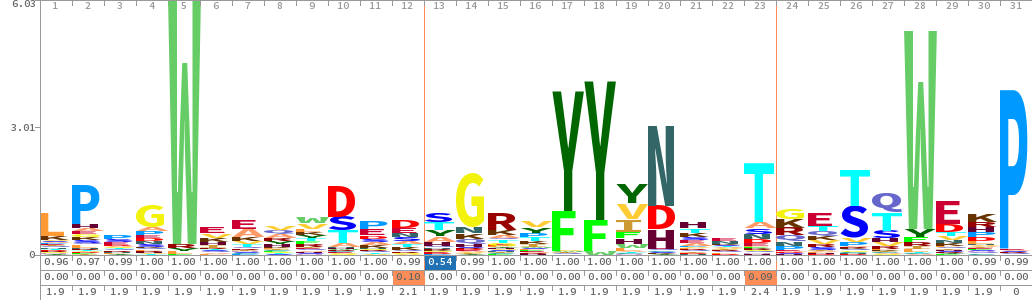

In [79]:
from IPython.display import Image
print("WW weblogo from http://weblogo.threeplusone.com:")
Image("WW-PF00397.png")
print("Keeping only the biggest acid we get something like: LPGWEEDGRYYN TTWP")

Logo generated with the file 'msaresults-CLUSTAL.fasta':


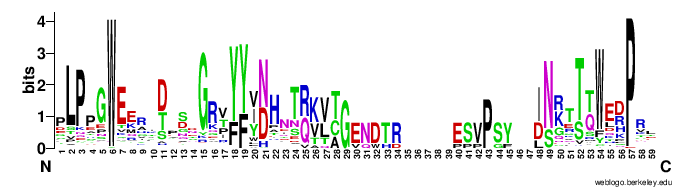

In [80]:
print("Logo generated with the file 'msaresults-CLUSTAL.fasta':")
Image("weblogo.berkeley.png")
print("Keeping only the biggest acid we get something like: LPGWEEDGRYYN TRKVTGENDTR ESVPSY TTWP")

As one can see, they are very similar, every "most important" acid in one of the profile is important too in the other (rigthmost 'P' for example or 'W' in the beginning of the two pictures)

A hand-made alignement of some of the biggest acid gives us a lot of similarities: 
* LPGWEEDGRYYN-TTWP
* LPGWEEDGRYYN-TRKVTGENDTR-ESVPSY-TTWP